# Laplace Approximation for Permanental Process

(Gaussian process prior + Squared link function + Poisson process + Laplace approximation)

Walder, C. J., & Bishop, A. N. (2017). Fast Bayesian Intensity Estimation for the Permanental Process. Proceedings of the 34th International Conference on Machine Learning, 3579–3588. https://proceedings.mlr.press/v70/walder17a.html

In [1]:
%%capture
%load_ext autoreload
%autoreload 2

In [ ]:
#! poetry install --group walder2017

In [78]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.stats import multivariate_normal
# import math
# from scipy.special import eval_hermite as hermite
# import pandas as pd

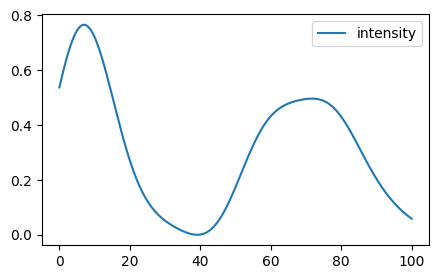

In [261]:
from scipy.stats import norm
from src.util.sampler import PointProcessGenerator

np.random.seed(0)

## Config
T = 100
xi=np.linspace(0+100/80/2,100-100/80/2,80)

n_grid = 1000
x=np.linspace(0,T,n_grid)
f=np.zeros(n_grid)
weight = norm.rvs(0,1,len(xi))

## Ground truth intensity function
def expo_quad_kernel(theta0,theta1,xn,xm):
    return theta0*np.exp(-theta1/2*np.sum((xn - xm)**2))

# strength = 1
strength = 0.3
for i in range(n_grid):
    for j in range(len(xi)):
        f[i] += weight[j] * expo_quad_kernel(strength,0.01,x[i],xi[j])
intensity=0.1*f**2 ## a_=0.1

plt.figure(1,figsize=(5,3))
axs=plt.subplot(111)
axs.plot(x,intensity,label='intensity')
# plt.tick_params(labelsize=10)
plt.legend()
plt.show()

points = PointProcessGenerator.inhomo_simulation(intensity,0.1,max(intensity),T)

In [270]:
len(points)

33

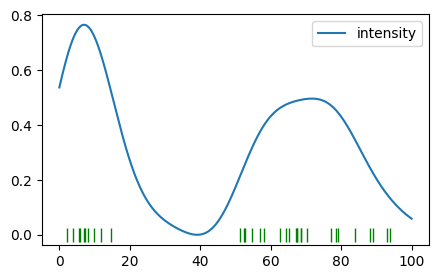

In [272]:
plt.figure(1,figsize=(5,3))
axs=plt.subplot(111)
axs.plot(x,intensity,label='intensity')
axs.plot(points,np.zeros(len(points)),linestyle='None', marker='|', color='g', markersize=10)
plt.legend()
plt.show()

Interval: 100
{x_i}: [[0.02306632 0.03786221 0.05522011 0.05895648 0.07066887 0.0739663
  0.08170789 0.09741304 0.11937136 0.14718955 0.51364081 0.52325708
  0.526172   0.54679121 0.568247   0.5818443  0.62741451 0.64452457
  0.65115894 0.67142501 0.67479549 0.67557643 0.68665519 0.68698162
  0.70184157 0.77249774 0.78670931 0.79202024 0.83861741 0.8809088
  0.89044795 0.92990495 0.93942184]]
data shape: (1, 33)
eval_points (up to 10) [0.         0.001001   0.002002   0.003003   0.004004   0.00500501
 0.00600601 0.00700701 0.00800801 0.00900901]
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -229.97779207934855
        x: [ 3.030e-02  3.030e-02 ...  3.030e-02  3.030e-02]
      nit: 0
      jac: [ 6.809e+01  6.808e+01 ...  6.675e+01  6.669e+01]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 53
     njev: 46
(1024, 1000)
(1024,)
[0.000918

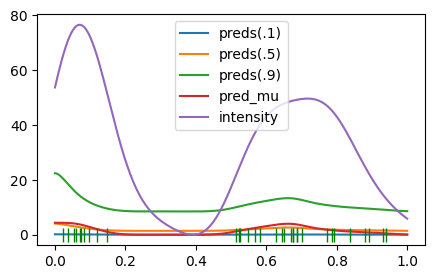

In [328]:
# Data
# Normalize to [0, 1] interval -> data is data/T, intensity is intensity*T.
data = np.array(points)[None,:]
data = data / T
true_intensity = intensity * T
eval_x = x[None,:] / T
# data = data
# true_intensity = intensity
# eval_x = x[None,:]

print('Interval:', T)
print('{x_i}:', data)
print('data shape:', data.shape)
print('eval_points (up to 10)', eval_x[0,:10])

# Generate kernels
# n_base_fn = 256
n_base_fn = 1024

from src.walder2017.kernels import Kernel
from src.walder2017.method import ModifiedKernel, Method, AlphaObjective

# a, b = 1e-5, 1e-5
# a, b = 1e-3, 1e-3
# a, b = 1e-6, 1e-2

# Fit model
kernel = Kernel(n_base_fn, a=1e-5, b=1e-6)
mod_kernel = ModifiedKernel(kernel)
features = kernel.feature_map(data)

method = Method(mod_kernel)
alpha = method.find_alpha(features)

# Predictive mean
preds = method.predict(eval_x, features, alpha)

preds_mu = method.laplace_mean(eval_x, features, alpha)

print('lik', method.marginal_likelihood(features, alpha))

# Compute variance
plt.figure(1,figsize=(5,3))
axs=plt.subplot(111)
axs.plot(eval_x[0],preds,label=['preds(.1)', 'preds(.5)', 'preds(.9)'])
axs.plot(eval_x[0],preds_mu**2,label='pred_mu')
axs.plot(eval_x[0],true_intensity,label='intensity')
axs.plot(data[0],np.zeros(len(points)),linestyle='None', marker='|', color='g', markersize=10)
# plt.tick_params(labelsize=10)
plt.legend()
plt.show()
# Select

18.914227938021348